Analyze the effect of treatment with chloroquine and/or oleic acid on the formation of solid, swiss cheese, and the total number of inclusions.

Import Libraries

In [1]:
import skimage
import numpy as np
import czifile
from czifile import CziFile
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
import numpy as np
from skimage.measure import regionprops
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.measure import label, regionprops
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.filters import try_all_threshold
import czifile as czi
import pandas as pd
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage import exposure
from skimage import morphology
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage import color, filters, feature, transform
from skimage.morphology import binary_dilation, disk, binary_erosion
from skimage import color, filters, feature, transform, draw
from os import listdir
from os.path import isfile, join
from cellpose import io, models, plot
from skimage import io, filters, feature, measure, color
from IPython.display import clear_output
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

In [2]:
from skimage import io
from matplotlib import pyplot as plt
def show_image(image):
    io.imshow(image)
    plt.show()

Define Sub Function

In [3]:
def detect_circular(green_channel):
    """
    Detects circular regions in the given green channel of an image.

    Args:
        green_channel: NumPy array representing the green channel of the image.

    Returns:
        None
    """
    # Adjust contrast using sigmoid adjustment
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.4)

    # Normalize the image to a [0, 1] range
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())

    # Detect edges using the Canny edge detector
    edges = feature.canny(confocal_img, sigma=3, low_threshold=0.1, high_threshold=0.3)

    # Perform distance transform and watershed segmentation
    distance = distance_transform_edt(np.invert(edges))
    local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=np.invert(edges))

    # Create marker image for watershed segmentation
    markers_image = np.zeros_like(distance, dtype=bool)
    markers_image[tuple(local_maxi.T)] = True
    markers = morphology.label(markers_image)

    # Apply watershed segmentation
    labels = watershed(-distance, markers, mask=np.invert(edges))

    # Detect and plot circular contours (plotting code removed as per request)
    for label in np.unique(labels):
        if label == 0:  # Skip background
            continue
        mask = (labels == label)
        contour = measure.find_contours(mask, level=0.5)[0]
        if len(contour) > 100: 
            pass  # Contour detection code placeholder (previously plotted the contours)


def combined_mask(red_channel, threshold_red):
    """
    Creates a combined mask based on overlap and threshold conditions.

    Args:
        red_channel: NumPy array representing the red channel of the image.
        threshold_red: Threshold value for the red channel.

    Returns:
        Combined boolean mask.
    """
    # Create a mask where the red channel has non-zero values
    overlap_mask = red_channel > 0

    # Apply Gaussian filter to the red channel
    blurred_red = gaussian(red_channel)

    # Create threshold masks
    threshold_mask1 = blurred_red < threshold_red
    threshold_mask2 = blurred_red > 0.01

    # Combine masks with logical AND
    combined_mask = overlap_mask & threshold_mask1 & threshold_mask2
    print("combined")
    show_image(combined_mask)
    return combined_mask


def mean_at_indices(val, str_list, int_list):
    """
    Calculates the mean of values in int_list at indices where str_list matches val.

    Args:
        val: The string value to match in str_list.
        str_list: A list of strings.
        int_list: A list of integers with the same length as str_list.

    Returns:
        The mean of the values in int_list at the indices where str_list matches val.
    """
    # Find indices where str_list matches val
    swiss_indices = []
    for i, value in enumerate(str_list):
        if value == val:
            swiss_indices.append(i)

    # Get values from int_list at matching indices and calculate the mean
    values_at_swiss_indices = np.array(int_list)[swiss_indices]
    return np.mean(values_at_swiss_indices)


def analyze_image(image_path, basename):
    """
    Analyzes a confocal image to detect cells, count inclusions, and identify types of inclusions.

    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each detected cell.
    """

    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    red_channel = image_squeezed[0, :, :]
    green_channel = image_squeezed[2, :, :]
    # show_image(green_channel)
    # blue_channel = image_squeezed[2, :, :]


    # Apply Gaussian filter and thresholding on the red channel
    threshold_red = threshold_otsu(gaussian(red_channel))
    red_channel_thresholded = gaussian(red_channel) > threshold_red
    show_image(red_channel_thresholded)
    # Create additional threshold masks for red channel
    red_channel_mid_thresh = combined_mask(red_channel, threshold_red)
    red_channel_low_thresh = gaussian(red_channel) < threshold_red

    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel, diameter=300, channels=[0, 0])
    # show_image(masks)
    labeled_cells = label(masks)

    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    swiss_counter = []
    solid_counter = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 300:  # Filter out small cells
            continue
        mask = labeled_cells == cell.label
        applied_mask = gaussian(green_channel) * mask
        threshold = 0.35
        inclusions = applied_mask > threshold
        print('Cell: ', i)
        
        inclusions_labeled = label(inclusions)

        swiss_or_solid = []  # Track types of inclusions
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]

        for inclusion in regionprops(inclusions_labeled):
            if inclusion.area > 10:
                inclusion_mask = inclusions_labeled == inclusion.label
                lipids_in_inclusions = inclusion_mask * gaussian(red_channel)
                lipids_in_inclusions = lipids_in_inclusions > 0.5
                lipids_in_inclusions_nonzeros = inclusion_mask & red_channel_thresholded

                # Determine inclusion type based on lipid presence
                if np.any(lipids_in_inclusions_nonzeros):
                    append = 'swiss'
                else:
                    append = 'solid'

                swiss_or_solid.append(append)

        # Store cell data
        cell_counter.append(i)
        cell_size.append(cell.area)
        num_inclusions.append(len(inclusion_areas))
        swiss_counter.append(swiss_or_solid.count("swiss"))
        solid_counter.append(swiss_or_solid.count("solid"))

        if len(inclusion_areas) >= 4: 
            show_image(inclusions)

    # Create and return the DataFrame
    df = pd.DataFrame({
        "Filename": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Cell_Size": cell_size,
        "Num_Inclusions": num_inclusions,
        "Solid_Inclusion_Count": solid_counter,
        "Swiss_Inclusion_Count": swiss_counter
    })
    return df


Define Main Function

mccc1_noOA_01.czi


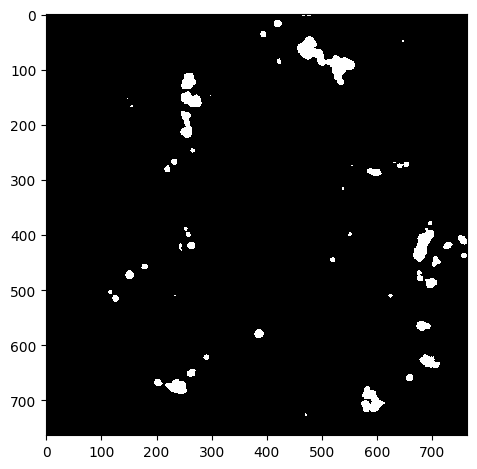

combined


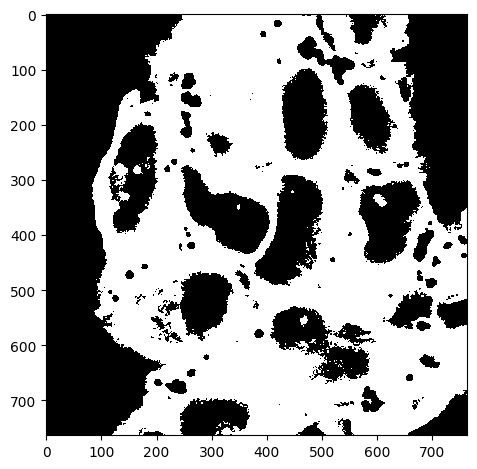

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
analyzation complete
mccc1_noOA_02.czi


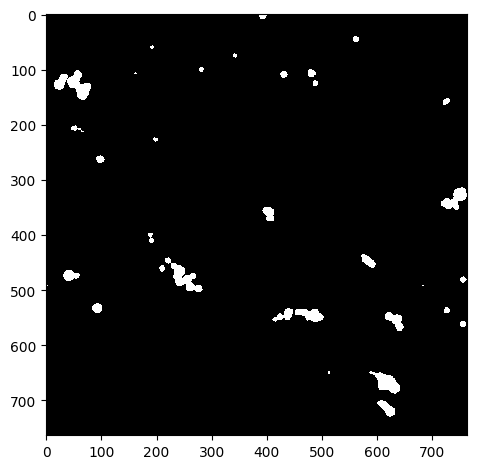

combined


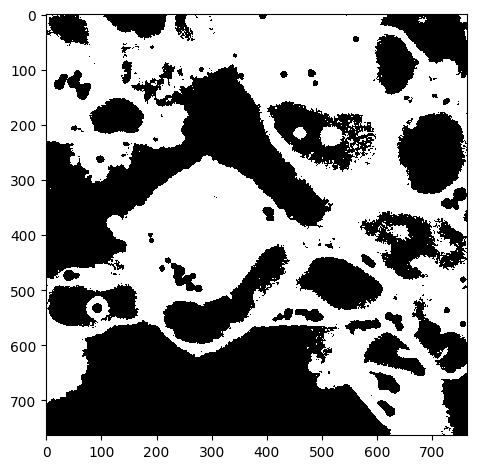

Cell:  0
Cell:  1
Cell:  2
Cell:  10
Cell:  11
Cell:  12
Cell:  13
Cell:  14
Cell:  15
Cell:  16
analyzation complete
mccc1_noOA_03.czi


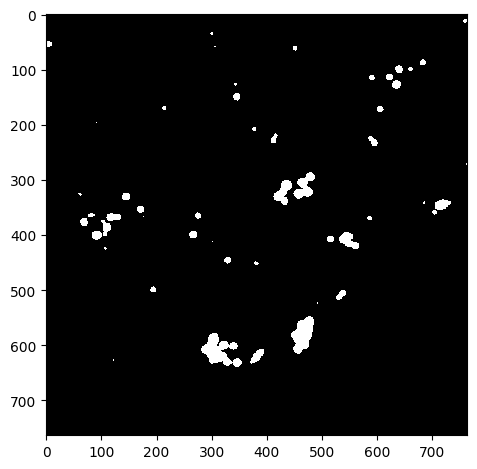

combined


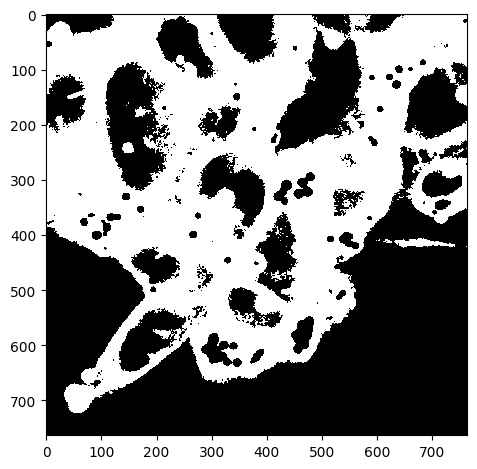

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5


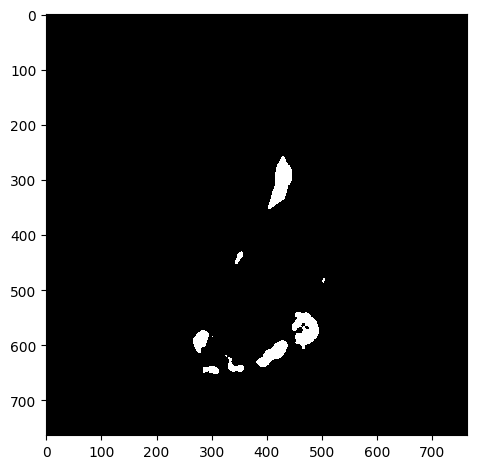

Cell:  6
Cell:  7
Cell:  8
analyzation complete
mccc1_noOA_04.czi


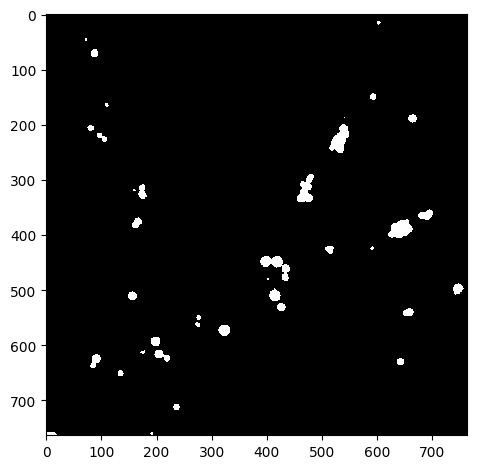

combined


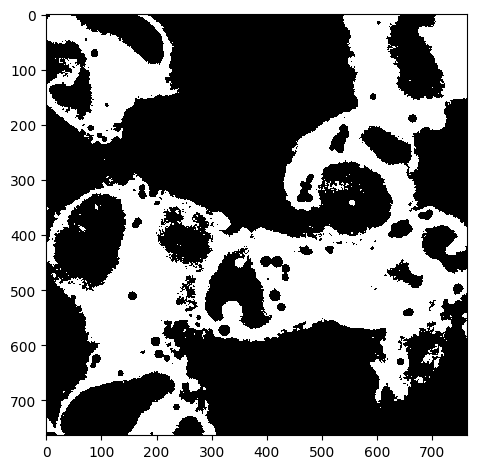

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
analyzation complete
mccc1_noOA_05.czi


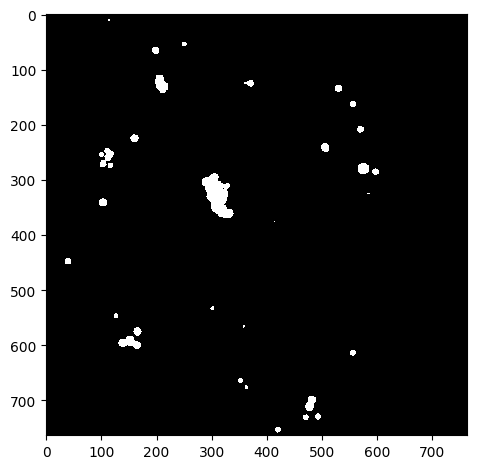

combined


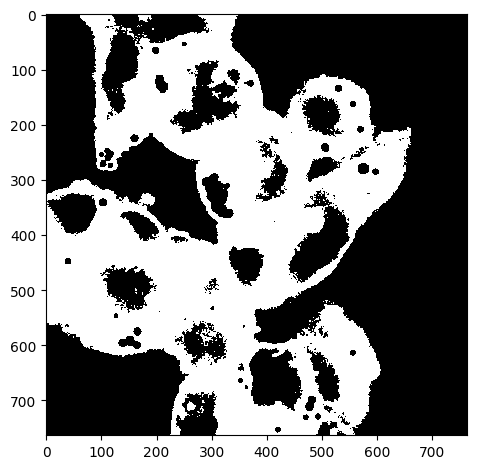

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
analyzation complete
mccc1_noOA_06.czi


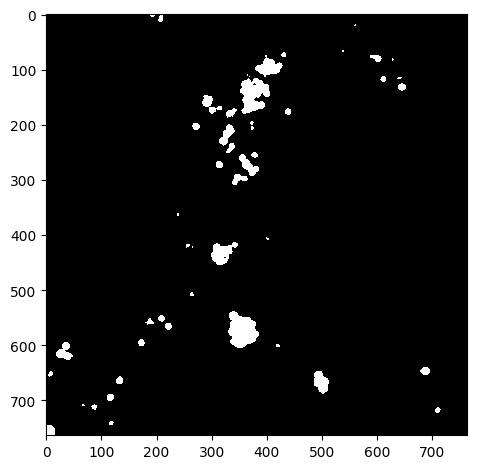

combined


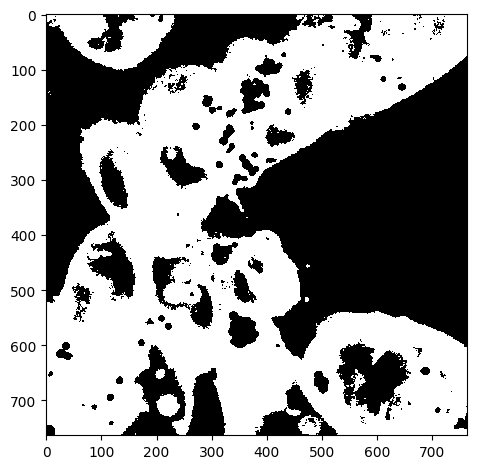

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
analyzation complete
mccc1_noOA_07.czi


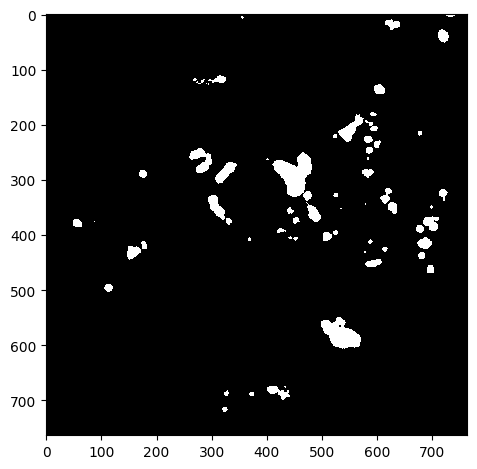

combined


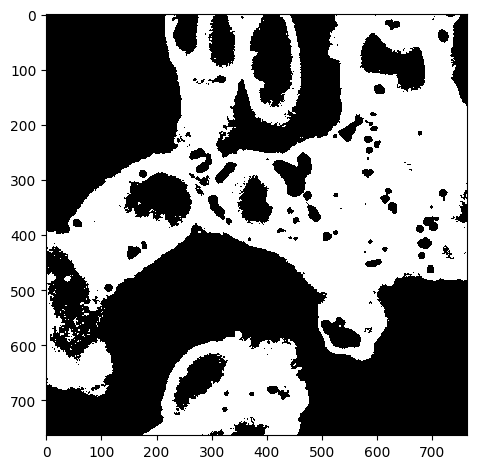

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5


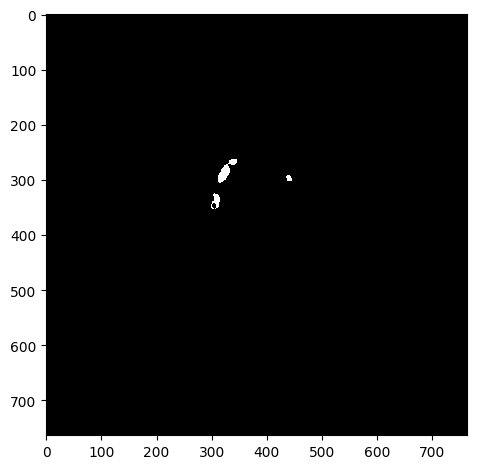

Cell:  6
Cell:  7
analyzation complete
mccc1_noOA_08.czi


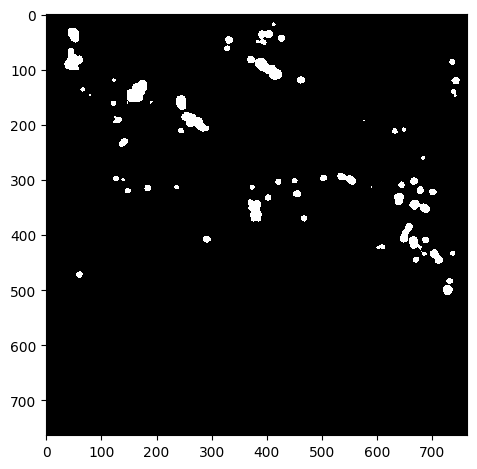

combined


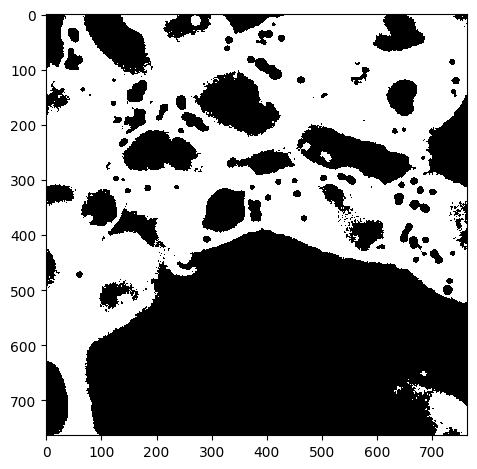

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4


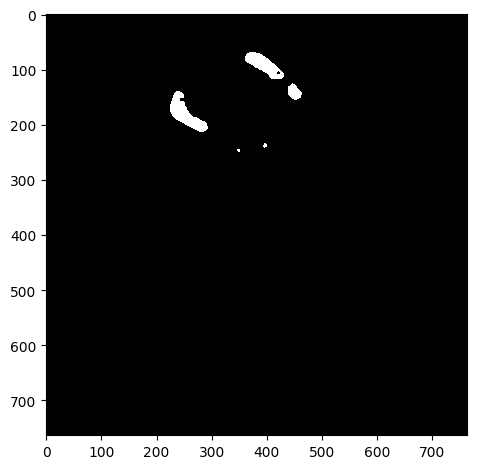

Cell:  5
Cell:  7
Cell:  8
Cell:  9
Cell:  10
Cell:  11
Cell:  12
Cell:  13
analyzation complete
scr_noOA_01.czi


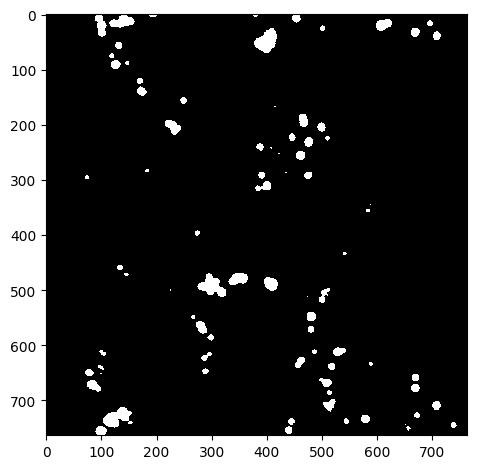

combined


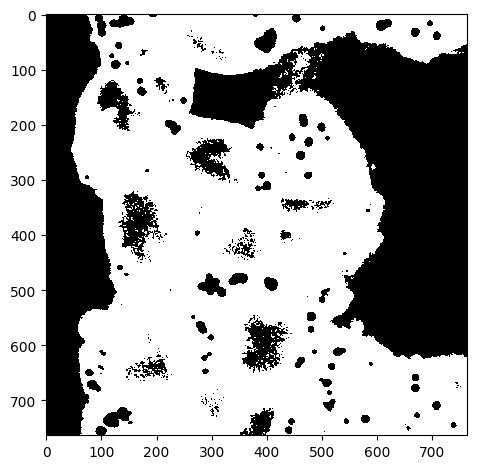

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
Cell:  10
Cell:  11
analyzation complete
scr_noOA_02.czi


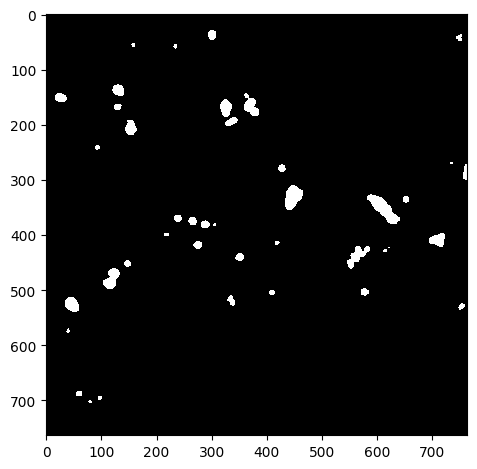

combined


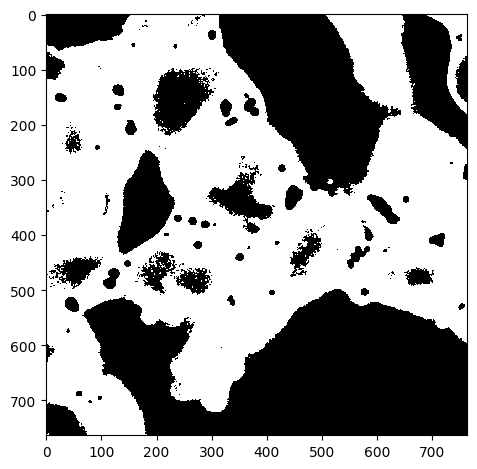

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
analyzation complete
scr_noOA_03.czi


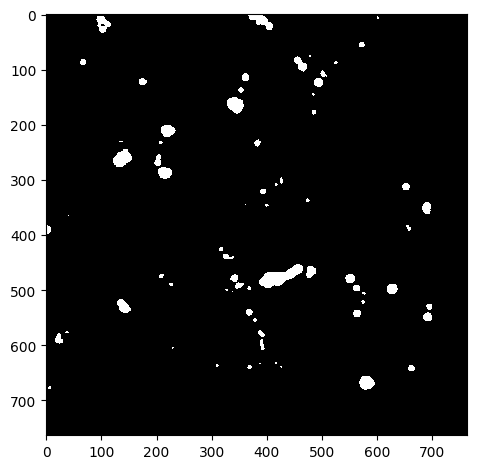

combined


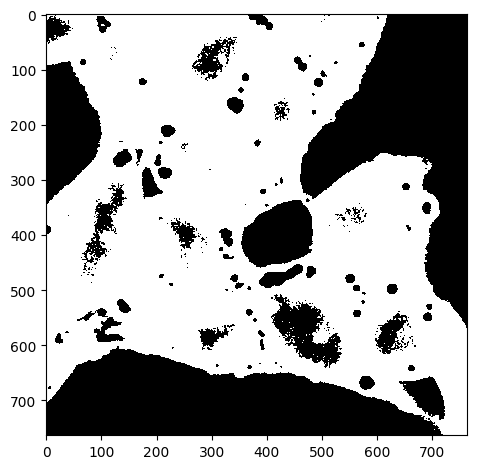

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
analyzation complete
scr_noOA_04.czi


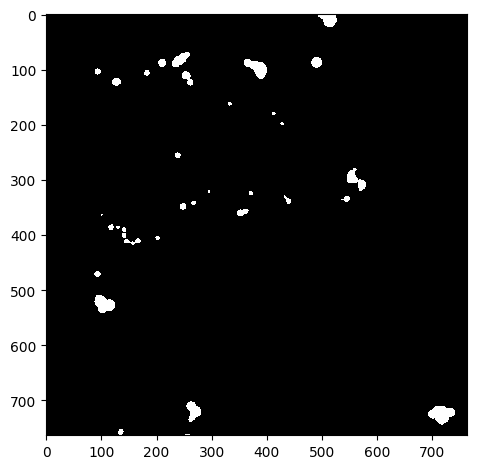

combined


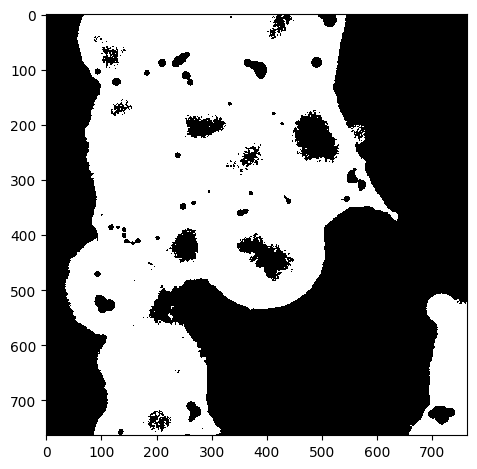

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
Cell:  10
Cell:  11
Cell:  12
analyzation complete
scr_noOA_05.czi


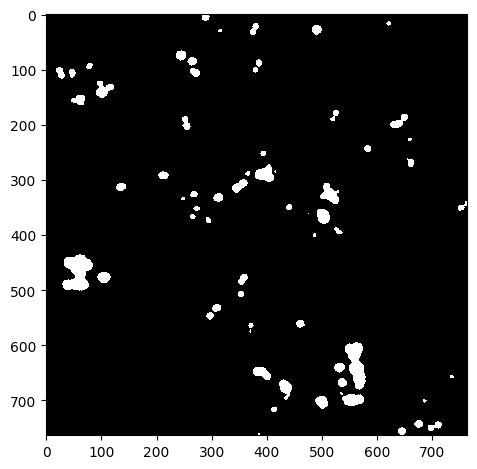

combined


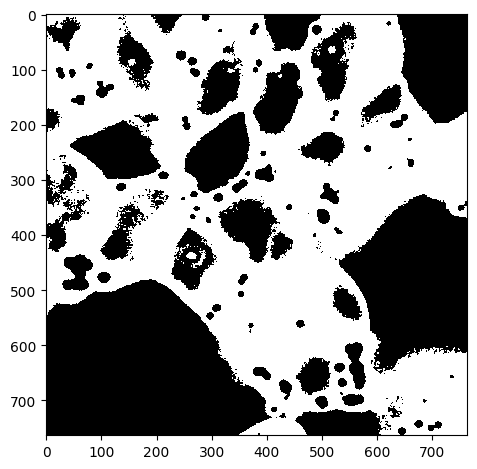

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  9
Cell:  11
Cell:  13
Cell:  14
analyzation complete
scr_noOA_06.czi


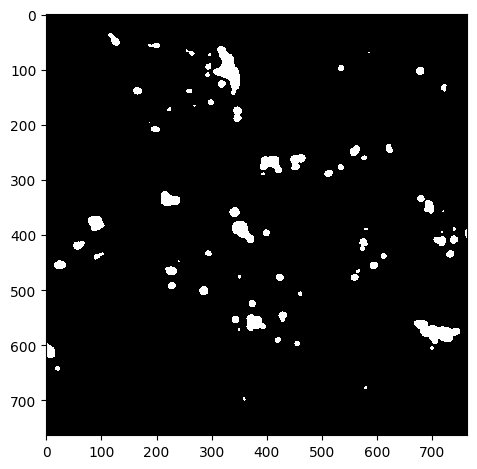

combined


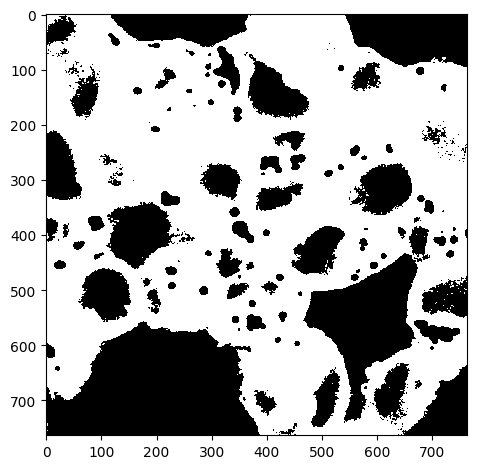

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  14
Cell:  18
Cell:  20
Cell:  21
Cell:  22
Cell:  23
Cell:  24
Cell:  25
analyzation complete
scr_noOA_07.czi


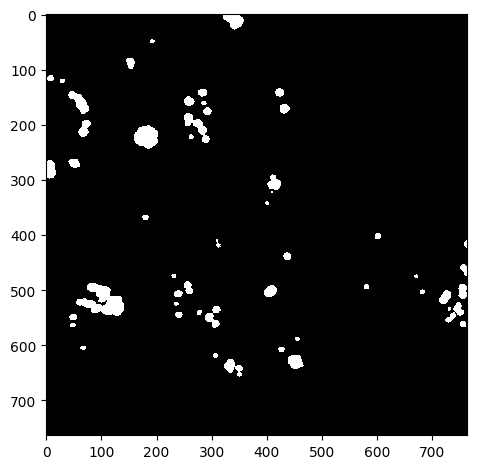

combined


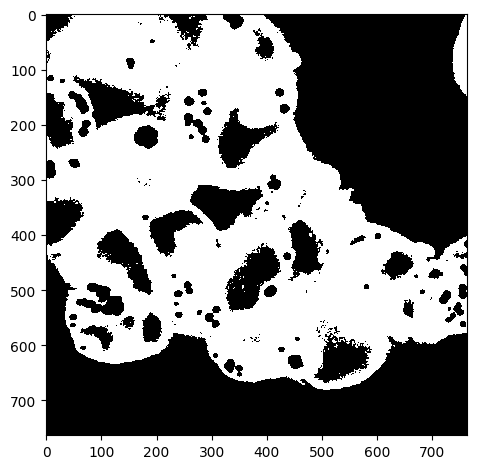

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
analyzation complete
scr_noOA_08.czi


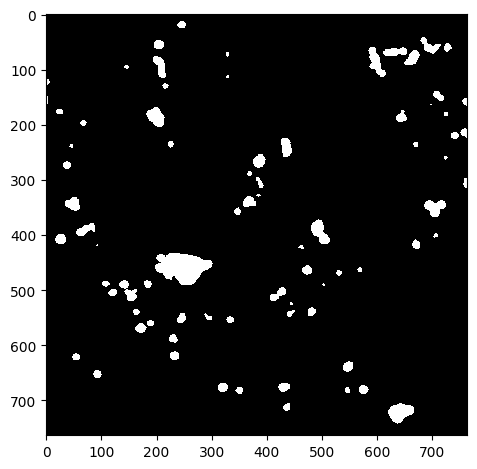

combined


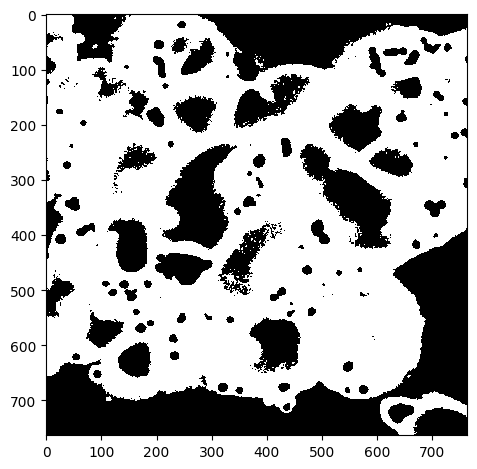

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7


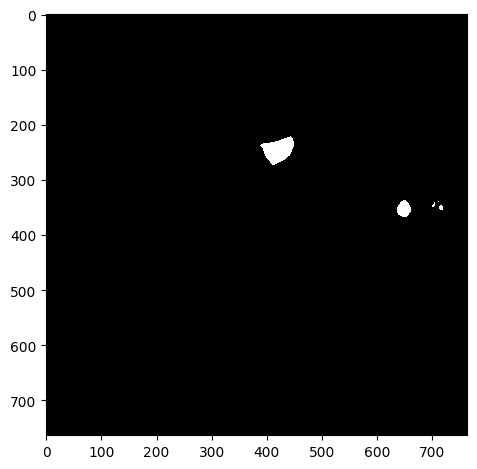

Cell:  9
Cell:  10
Cell:  11
Cell:  12
Cell:  13
analyzation complete
stk39_noOA_01.czi


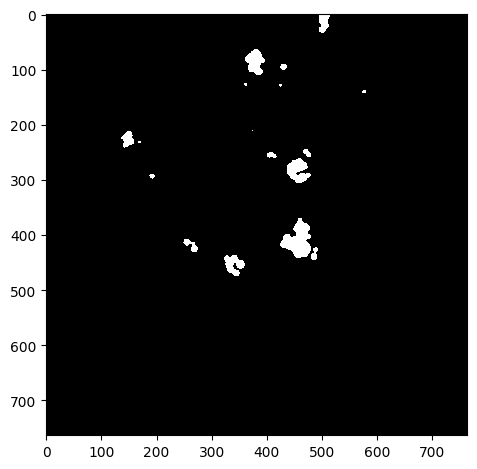

combined


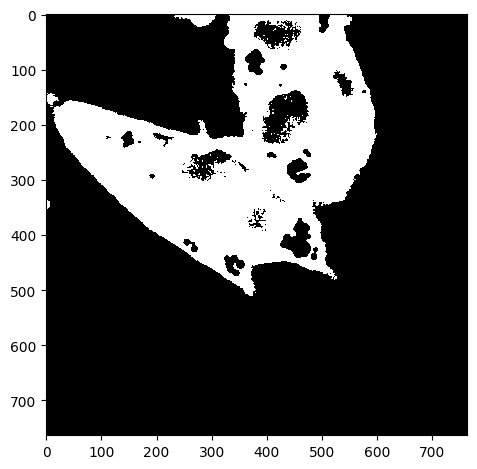

Cell:  0
Cell:  1


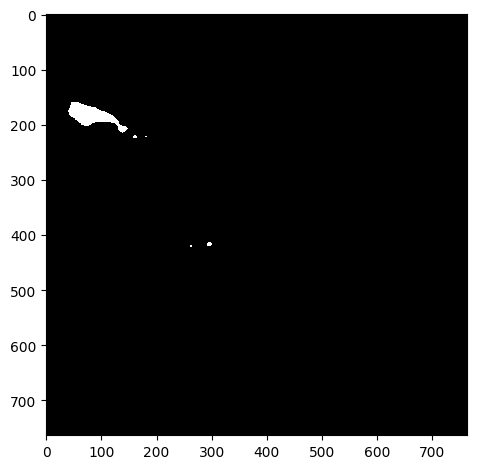

Cell:  2


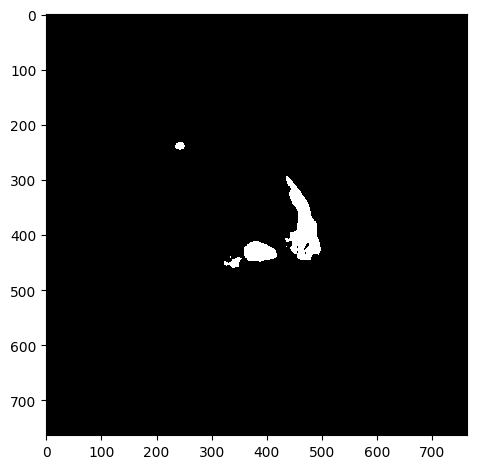

analyzation complete
stk39_noOA_02.czi


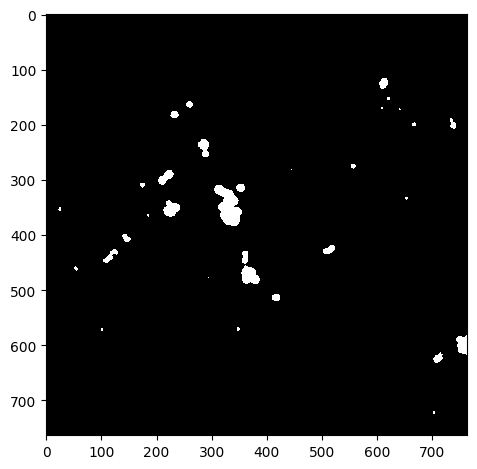

combined


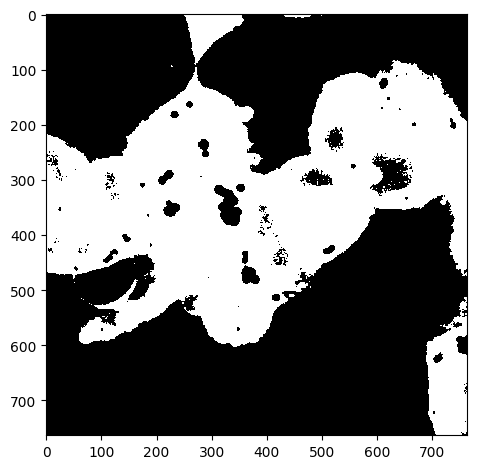

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  10
Cell:  11
analyzation complete
stk39_noOA_03.czi


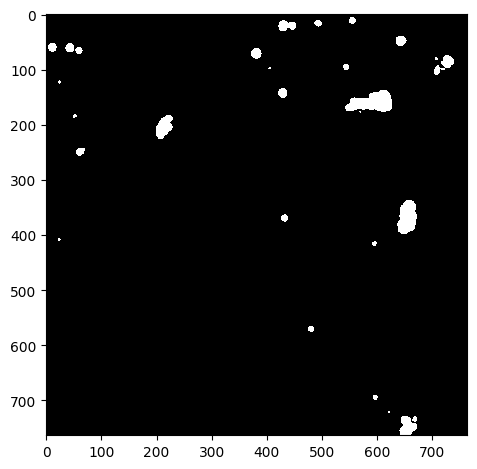

combined


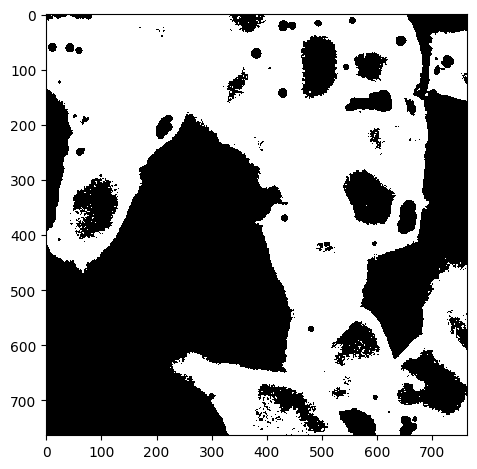

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7


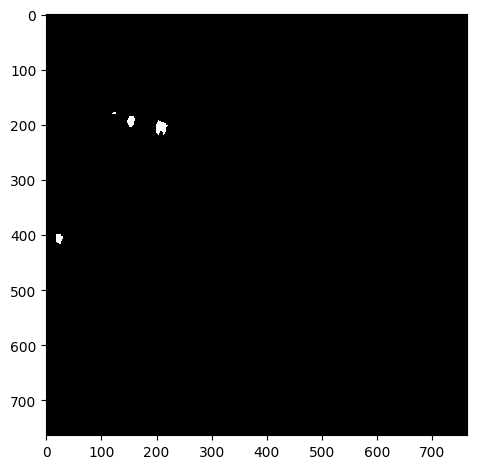

Cell:  8
Cell:  9
Cell:  10
Cell:  11
analyzation complete
stk39_noOA_04.czi


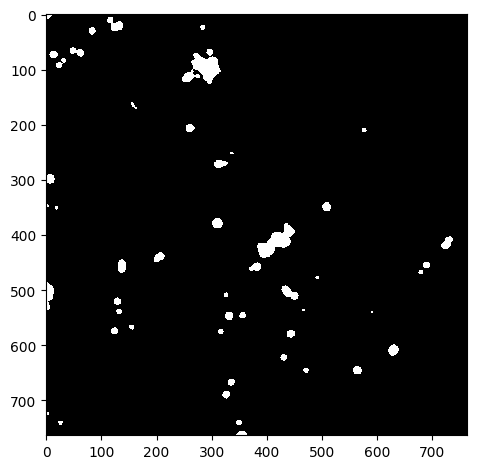

combined


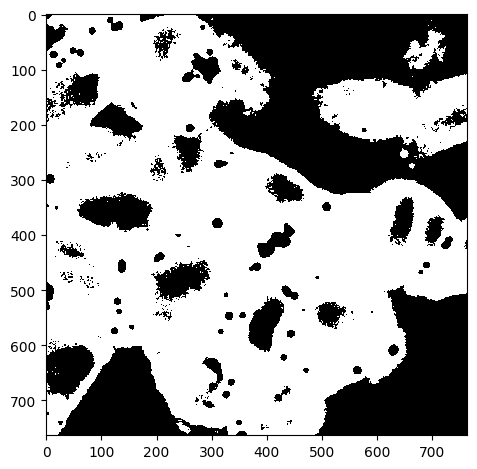

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  4


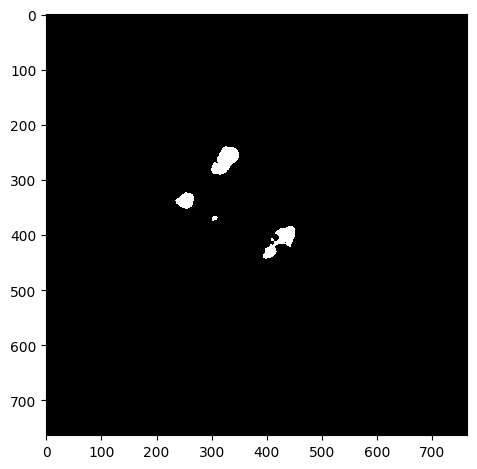

Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
Cell:  10
Cell:  11
Cell:  12
Cell:  13
analyzation complete
stk39_noOA_05.czi


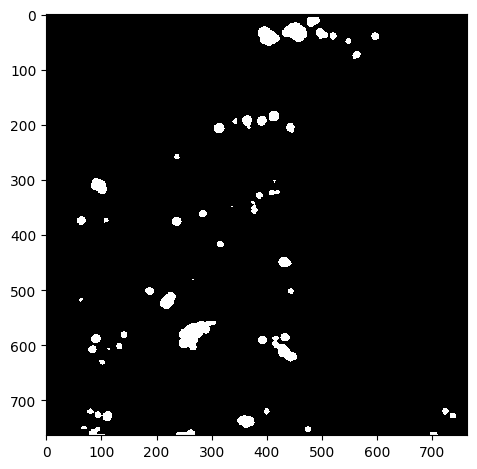

combined


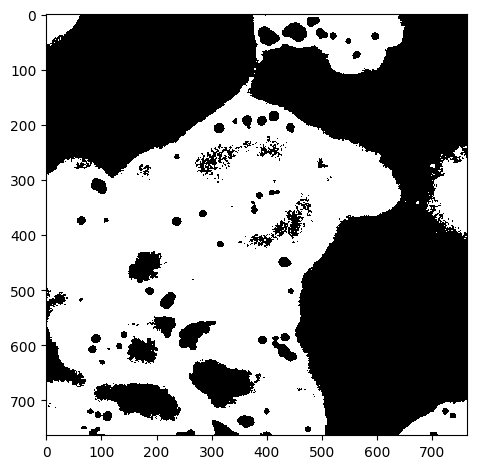

Cell:  0
Cell:  1


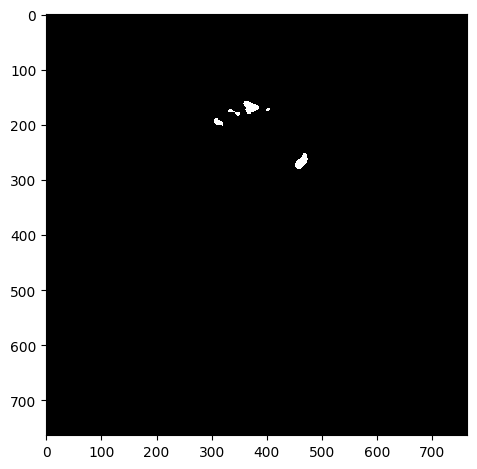

Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
analyzation complete
stk39_noOA_06.czi


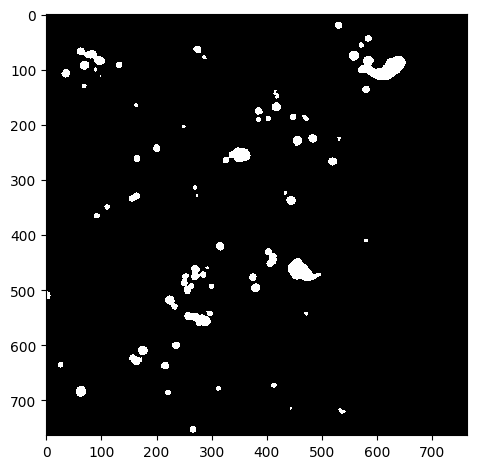

combined


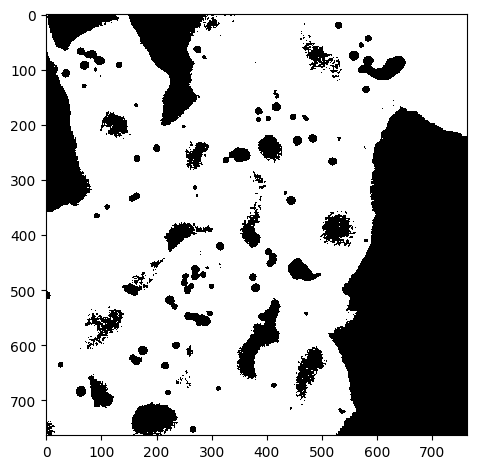

Cell:  0
Cell:  1


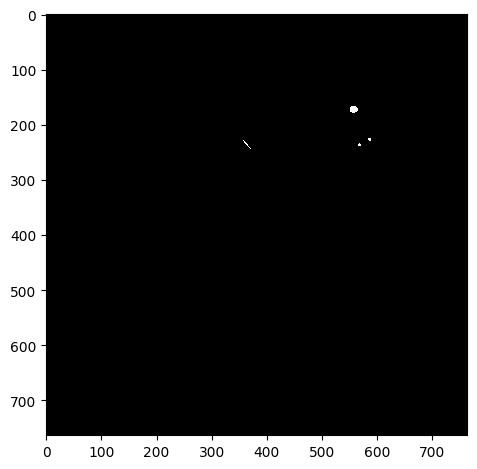

Cell:  2
Cell:  3
Cell:  4
Cell:  5
Cell:  6
Cell:  7
Cell:  8
Cell:  9
Cell:  11
Cell:  12
analyzation complete
stk39_noOA_07.czi


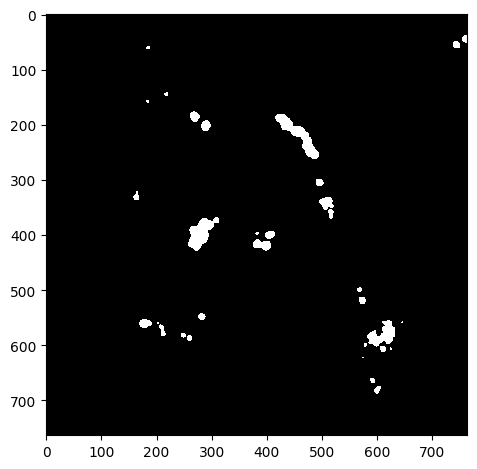

combined


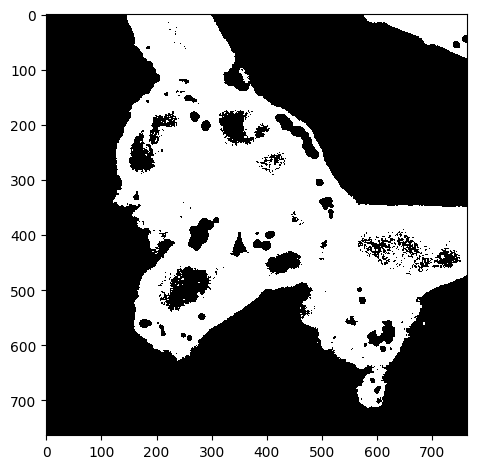

Cell:  0
Cell:  1
Cell:  2
Cell:  3


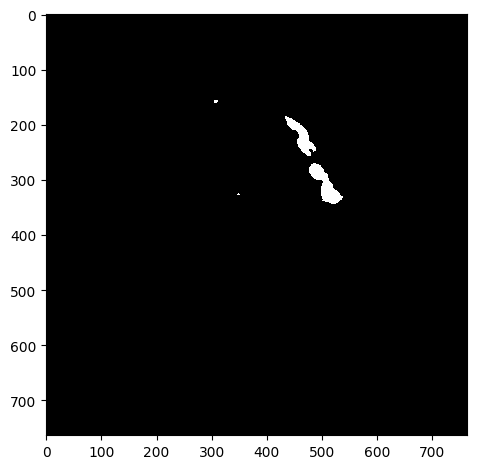

Cell:  4
Cell:  5
Cell:  6
analyzation complete
stk39_noOA_08.czi


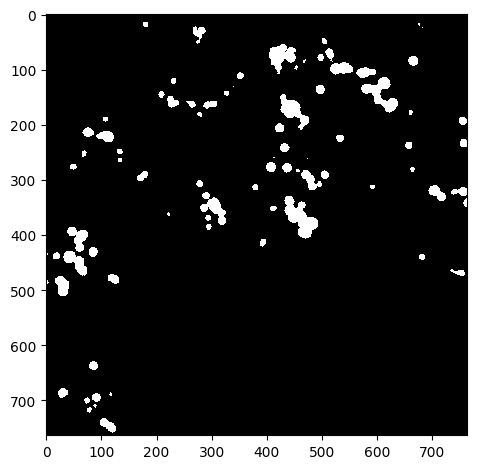

combined


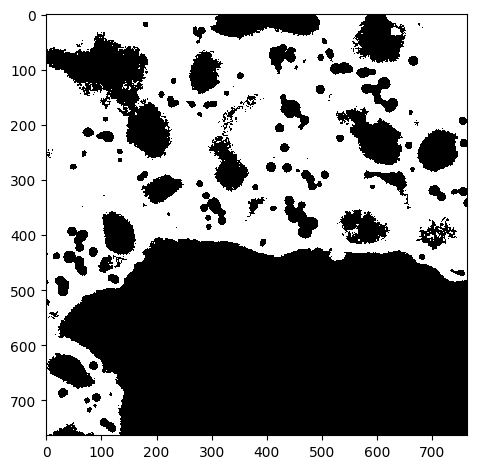

Cell:  0
Cell:  1
Cell:  2
Cell:  3
Cell:  5
Cell:  7
Cell:  8
Cell:  9
Cell:  10
Cell:  11
Cell:  13
Cell:  14
Cell:  15
analyzation complete


: 

In [ ]:
all_data = []
# folder_path = r'101824_mccc1stk39_lipidtox_live'
folder_path = '092624_mccc1_stk39_lipidtox_live_noOA'
for well_image in os.listdir(folder_path):
    print(well_image)
    
    if well_image.lower().endswith(".czi"):  # Filter for CZI files
        well_image_path = os.path.join(folder_path, well_image)
        well_image_base_name = os.path.basename(well_image)[:-4]
        try:
            df = analyze_image(well_image_path, well_image_base_name)
            all_data.append(df)
            print("analyzation complete")
        except:
            print("error")
            continue



combined_df = pd.concat(all_data, ignore_index=True)

# Save the combined DataFrame to a single CSV
# combined_csv_path = os.path.join(f"OA_CH_Live_Cells_{folder_path[:6]}_noOA.xlsx")
# ombined_df.to_excel(combined_csv_path, index=False)
